# 1. Import libraries

In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

# From here, add any libraries that you might need for the rest of your code
import random
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import keras_tuner as kt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support

from tensorflow.keras.applications import ResNet50, VGG16, DenseNet121
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_pre
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_pre
from tensorflow.keras.applications.densenet import preprocess_input as densenet_pre

# 2. Load and pre-process the dataset

In [13]:
# set this path to the directory where you stored the dataset
dataset_dir = "data/Train" 

# LIST THE CLASSES THAT EXIST WITHIN THIS DATASET:
CLASS_LABELS  = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC'] # creates a list of the 8 classes in this dataset (the dataset contains images of 8 types of skin lesion)
# note: class names are abbreviations for:
# ["Actinic Keratoses", "Basal Cell Carcinoma", "Benign Keratosis-like Lesions", "Dermatofibroma", "Melanoma", "Nevus", "Squamous Cell Carcinoma", "Vascular Lesions"]


In [14]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# LOAD AND PREPROCESS THE DATA:

# set size of images (in pixels) after resizing
IMG_HEIGHT = 42
IMG_WIDTH = 42

# set batch size
BATCH_SIZE = 128

# set relative sizes of the test and val set
TEST_SIZE = 0.2   # 20% of all 27.934 images will be used for testing the model
VAL_SIZE = 0.2    # of the remaining images, 20% will be used for validation and 80% for training

# function for adding noise to the images
def add_noise(img):
    std_coeff = 20 * np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    img = np.clip(img, 0., 255.)
    return img

# build dataframe with file paths and labels
all_files = []
all_labels = []

for class_name in sorted(os.listdir(dataset_dir)):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            all_files.append(fpath)
            all_labels.append(class_name)

df = pd.DataFrame({"filename": all_files, "class": all_labels})

# split the data into train / val / test
trainval_df, test_df = train_test_split(df, test_size=TEST_SIZE, stratify=df["class"], random_state=31) # split all data into trainval + test
train_df, val_df   = train_test_split(trainval_df, test_size=VAL_SIZE, stratify=trainval_df["class"], random_state=31)  # split trainval data into train + val

# define generators
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise) # note: noise is only added to the train samples.
val_test_datagen = ImageDataGenerator(rescale=1./255)

# apply generators
train_data = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=7
)

val_data = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="class",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=7
)

test_data = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="class",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("Data loading completed successfully.")
print(f"Number of training samples: {train_data.samples}")
print(f"Number of validation samples: {val_data.samples}")
print(f"Number of test samples: {test_data.samples}")
print(f"Class names: {train_data.class_indices}")

Found 17877 validated image filenames belonging to 8 classes.
Found 4470 validated image filenames belonging to 8 classes.
Found 5587 validated image filenames belonging to 8 classes.
Data loading completed successfully.
Number of training samples: 17877
Number of validation samples: 4470
Number of test samples: 5587
Class names: {'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}


## 2.2 Configuration & Reproducibility
Set seeds.

In [15]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
NUM_CLASSES = len(CLASS_LABELS)

# 3. Visualise data and plot data distribution

### 3.1 Functions

In [16]:
def show_random_grid(generator, n=15, cols=5, seed=SEED, title="Random samples"):
    """
    Display n random images with labels from a Keras generator that uses flow_from_dataframe.
    Assumes generator has .filepaths, .classes, and .class_indices.
    """
    rnd = random.Random(seed)
    idxs = rnd.sample(range(len(generator.filepaths)), n)
    class_inv = {v: k for k, v in generator.class_indices.items()}
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols * 2.4, rows * 2.4))
    for i, idx in enumerate(idxs):
        # Load the raw image path and label
        path = generator.filepaths[idx]
        label_id = generator.classes[idx]
        label = class_inv[label_id]
        # Read image via keras utils
        img = tf.keras.utils.load_img(path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(label, fontsize=9)
    plt.suptitle(title, y=0.98)
    plt.tight_layout()
    plt.show()

def plot_class_distribution(generator, title="Class distribution"):
    classes = np.asarray(generator.classes)
    class_inv = {v: k for k, v in generator.class_indices.items()}
    labels = [class_inv[i] for i in sorted(set(classes))]
    counts = [int(np.sum(classes == i)) for i in range(len(labels))]
    plt.figure(figsize=(8, 4))
    plt.bar(labels, counts)
    plt.ylabel("Count")
    plt.title(title)
    for i, c in enumerate(counts):
        plt.text(i, c, str(c), ha='center', va='bottom', fontsize=8)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


### 3.2 Visualization

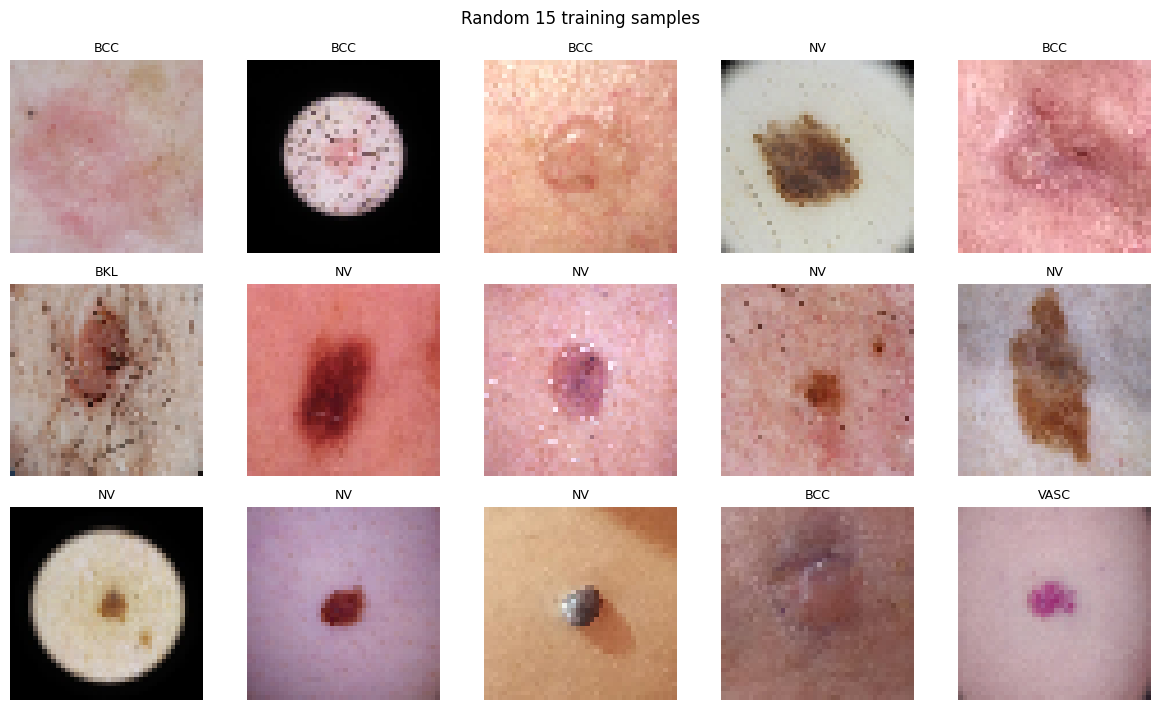

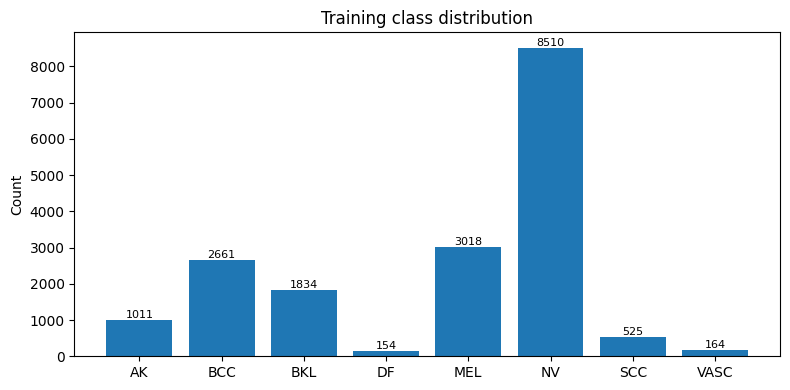

In [17]:
show_random_grid(train_data, n=15, cols=5, seed=SEED, title="Random 15 training samples")
plot_class_distribution(train_data, title="Training class distribution")

# 4. Common Functions

### 4.1 Traing helpers & history plots

In [18]:
def train_model(model, train_gen, val_gen, epochs=15, early_stopping=False):
    steps_per_epoch = int(np.ceil(train_gen.samples / train_gen.batch_size))
    val_steps = int(np.ceil(val_gen.samples / val_gen.batch_size))

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True))

    hist = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=val_steps,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    return hist


def plot_history(hist, title_prefix="Baseline"):
    h = hist.history
    epochs = range(1, len(h['loss']) + 1)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, h['loss'], label='train')
    plt.plot(epochs, h['val_loss'], label='val')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title(f"{title_prefix} Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, h['accuracy'], label='train')
    plt.plot(epochs, h['val_accuracy'], label='val')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title(f"{title_prefix} Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

### 4.2 Evaluation functions

In [19]:
def _predict_generator(model, gen):
    """
    Run model.predict on a Keras generator and return (y_true, y_pred, y_prob).
    """
    steps = int(np.ceil(gen.samples / gen.batch_size))
    y_prob = model.predict(gen, steps=steps, verbose=0)
    y_true = gen.classes
    y_pred = np.argmax(y_prob, axis=1)
    return y_true, y_pred, y_prob


def plot_confusion(gen, y_true, y_pred, title="Confusion matrix"):
    """
    Confusion matrix with class labels taken from generator.class_indices.
    """
    class_inv = {v: k for k, v in gen.class_indices.items()}
    labels = [class_inv[i] for i in range(len(class_inv))]

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(title)
    plt.tight_layout(); plt.show()


def plot_multiclass_roc(gen, y_true, y_prob, title="ROC (one-vs-rest)"):
    """
    One-vs-rest ROC curves with micro and macro averages for multi-class.
    """
    class_inv = {v: k for k, v in gen.class_indices.items()}
    n_classes = len(class_inv)

    # Binarize true labels for OvR curves
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot
    plt.figure(figsize=(7, 6))
    class_names_ordered = [class_inv[i] for i in range(n_classes)]
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 label=f"{class_names_ordered[i]} (AUC={roc_auc[i]:.3f})",
                 alpha=0.8)
    plt.plot(fpr["micro"], tpr["micro"],
             label=f"micro-average (AUC={roc_auc['micro']:.3f})",
             linestyle='--')
    plt.plot(fpr["macro"], tpr["macro"],
             label=f"macro-average (AUC={roc_auc['macro']:.3f})",
             linestyle='--')
    plt.plot([0, 1], [0, 1], linestyle=':')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title(title)
    plt.legend()
    plt.tight_layout(); plt.show()


def report_metrics(y_true, y_pred, average='macro'):
    """
    Prints and returns (accuracy, precision, recall, f1) for a given averaging scheme.
    """
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=average, zero_division=0
    )
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision ({average}): {prec:.4f}")
    print(f"Recall ({average}): {rec:.4f}")
    print(f"F1-score ({average}): {f1:.4f}")
    return acc, prec, rec, f1


def full_evaluation(model, gen, split_name="Test"):
    """
    Runs predictions, prints macro & weighted metrics, shows confusion matrix,
    plots multi-class ROC with micro/macro AUC, and prints a per-class report.
    """
    y_true, y_pred, y_prob = _predict_generator(model, gen)

    print(f"\n=== {split_name} metrics (macro) ===")
    report_metrics(y_true, y_pred, average='macro')

    print(f"\n=== {split_name} metrics (weighted) ===")
    report_metrics(y_true, y_pred, average='weighted')

    plot_confusion(gen, y_true, y_pred, title=f"{split_name} Confusion Matrix")
    plot_multiclass_roc(gen, y_true, y_prob, title=f"{split_name} ROC")

    print("\nClassification report (per-class):\n")
    class_inv = {v: k for k, v in gen.class_indices.items()}
    target_names = [class_inv[i] for i in range(len(class_inv))]
    print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

# 5. Baseline Model

### 5.1 Design
Two Conv blocks (3x3, 16 filters) each followed by MaxPool 2x2; Flatten; Dense 1600→128 (ReLU); Dense 128→8 (Softmax).

In [10]:
def build_baseline_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape)
    # Block 1
    x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    # Block 2
    x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    # Flatten → Dense 1600 → 128
    x = layers.Flatten()(x)
    x = layers.Dense(1600, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    # Output logits → Softmax
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs, name='BaselineCNN')
    return model

def compile_baseline(model, lr=1e-3):
    opt = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',  # use 'sparse_categorical_crossentropy' if you switch to integer labels
                  metrics=['accuracy'])
    return model

### 5.2 Train

In [ ]:
baseline = build_baseline_model()
baseline = compile_baseline(baseline, lr=1e-3)
hist_baseline = train_model(baseline, train_data, val_data, epochs=15)
baseline.save('baseline_skin_lesion_model.h5')

Epoch 1/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 0.5249 - loss: 1.3188 - val_accuracy: 0.5725 - val_loss: 1.1889 - learning_rate: 0.0010
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step - accuracy: 0.5779 - loss: 1.1644 - val_accuracy: 0.5951 - val_loss: 1.1301 - learning_rate: 0.0010
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 0.6004 - loss: 1.1071 - val_accuracy: 0.6081 - val_loss: 1.0852 - learning_rate: 0.0010
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.6114 - loss: 1.0708 - val_accuracy: 0.6152 - val_loss: 1.0718 - learning_rate: 0.0010
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.6263 - loss: 1.0453 - val_accuracy: 0.6130 - val_loss: 1.0608 - learning_rate: 0.0010
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.6314 - loss: 1.0172 - val_accuracy: 0.6000 - val_loss: 1.0931 - learning_rate: 0.0010
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.6

### 5.3 Evaluation

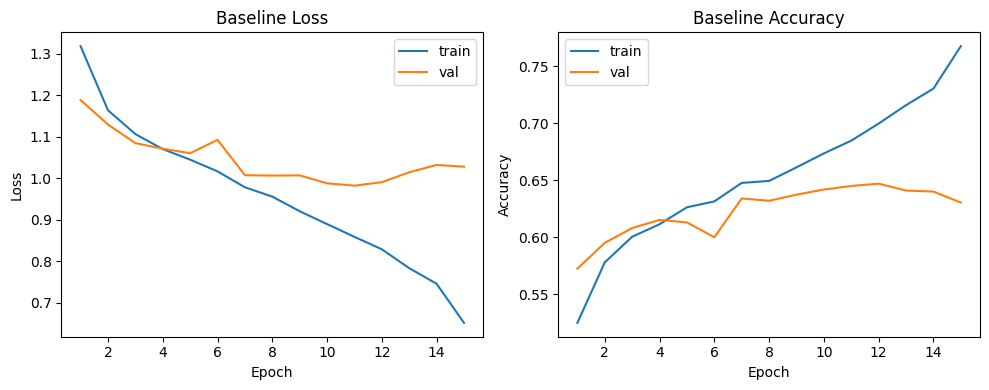

In [12]:
plot_history(hist_baseline, title_prefix="Baseline")


=== Test metrics (macro) ===
Accuracy: 0.6320
Precision (macro): 0.5202
Recall (macro): 0.4120
F1-score (macro): 0.4278

=== Test metrics (weighted) ===
Accuracy: 0.6320
Precision (weighted): 0.6374
Recall (weighted): 0.6320
F1-score (weighted): 0.6294


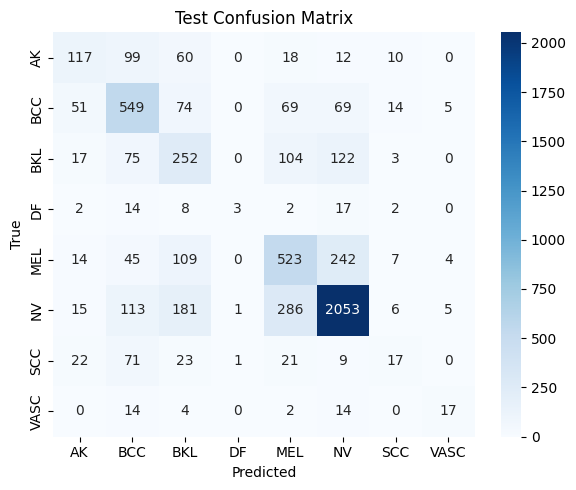

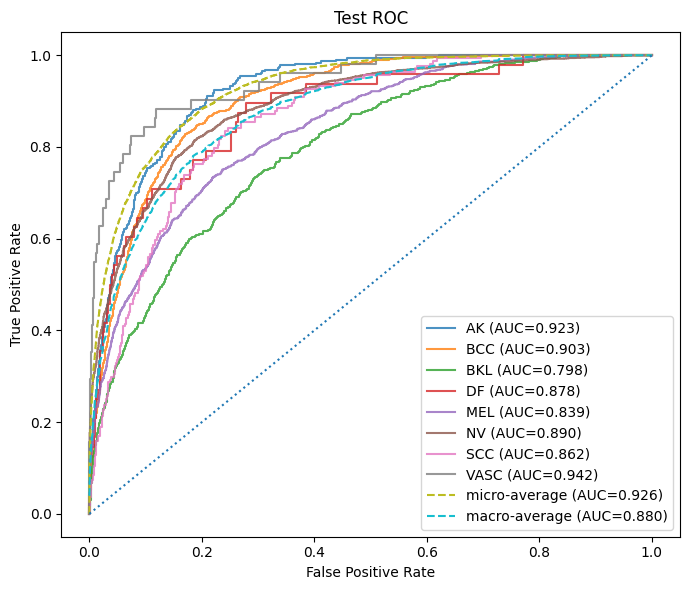


Classification report (per-class):

              precision    recall  f1-score   support

          AK       0.49      0.37      0.42       316
         BCC       0.56      0.66      0.61       831
         BKL       0.35      0.44      0.39       573
          DF       0.60      0.06      0.11        48
         MEL       0.51      0.55      0.53       944
          NV       0.81      0.77      0.79      2660
         SCC       0.29      0.10      0.15       164
        VASC       0.55      0.33      0.41        51

    accuracy                           0.63      5587
   macro avg       0.52      0.41      0.43      5587
weighted avg       0.64      0.63      0.63      5587



In [13]:
full_evaluation(baseline, test_data, split_name="Test")

# 6. Improved model

### 6.1 Design

In [20]:
class ImprovedCNN(tf.keras.Model):
    """
    Flexible CNN with tunable depth/width/regularization for purposeful hyperparameter studies.
    Hyperparams:
      - base_filters: #filters in the first conv block (doubles each block)
      - blocks: number of conv blocks (Conv2D -> [BN] -> Act -> MaxPool)
      - dense_units: width of the first dense layer
      - dropout_rate: dropout after dense layer
      - use_bn: whether to use BatchNorm after convs and before dense activation
      - activation: activation function name (e.g., 'relu', 'gelu', 'leaky_relu' via layers.Activation)
    """
    def __init__(self, base_filters=32, blocks=3, dense_units=256,
                 dropout_rate=0.3, use_bn=True, activation='relu'):
        super().__init__()
        self.use_bn = use_bn
        self.activation = activation

        # Feature extractor
        self.features = []
        filters = base_filters
        for _ in range(blocks):
            self.features.append(layers.Conv2D(filters, (3, 3), padding='same'))
            if use_bn:
                self.features.append(layers.BatchNormalization())
            self.features.append(layers.Activation(activation))
            self.features.append(layers.MaxPooling2D((2, 2)))
            filters *= 2

        # Classifier head
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(dense_units)
        self.bn1 = layers.BatchNormalization() if use_bn else None
        self.act1 = layers.Activation(activation)
        self.drop = layers.Dropout(dropout_rate)
        self.out = layers.Dense(NUM_CLASSES, activation='softmax')

    def call(self, x, training=False):
        for layer in self.features:
            # Ensure BN layers receive 'training' flag
            if isinstance(layer, layers.BatchNormalization):
                x = layer(x, training=training)
            else:
                x = layer(x)
        x = self.flatten(x)
        x = self.fc1(x)
        if self.bn1 is not None:
            x = self.bn1(x, training=training)
        x = self.act1(x)
        x = self.drop(x, training=training)
        return self.out(x)


def build_improved_model(lr=3e-4, **kwargs):
    """
    Factory that builds, builds the graph, and compiles ImprovedCNN.
    Usage example:
        improved = build_improved_model(
            lr=3e-4, base_filters=32, blocks=3,
            dense_units=256, dropout_rate=0.4, use_bn=True, activation='relu'
        )
    """
    model = ImprovedCNN(**kwargs)
    # Build the graph with known input shape so model.summary() works immediately
    model.build((None, IMG_HEIGHT, IMG_WIDTH, 3))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### 6.3 Coarse architecture sweep
Use  <a href="https://arxiv.org/abs/1603.06560">Random Search</a> for hyper-parameter optimization. Random samplig of number of blocks, number of filters and number of dense units and train the sampled models for a small number of ecpochs with early stopping for cheap architecture search.

In [33]:
N_SWEEP = 12  # Number of random architectures to try
EPOCHS = 8    # Small epoch budget

# Search space
blocks_range = [2, 3, 4, 5]
filters_range = [16, 32, 48, 64]
dense_range = [128, 256, 384, 512]
dropout_range = [0.2, 0.3, 0.4]
activation_range = ['relu', 'gelu']

results = []

for i in range(N_SWEEP):
    # Randomly sample hyperparameters
    blocks = random.choice(blocks_range)
    base_filters = random.choice(filters_range)
    dense_units = random.choice(dense_range)
    dropout_rate = random.choice(dropout_range)
    activation = random.choice(activation_range)
    use_bn = True

    print(f"\nSweep {i+1}/{N_SWEEP}: blocks={blocks}, filters={base_filters}, dense={dense_units}, dropout={dropout_rate}, act={activation}")

    # Build and train model
    model = build_improved_model(
        lr=3e-4,
        base_filters=base_filters,
        blocks=blocks,
        dense_units=dense_units,
        dropout_rate=dropout_rate,
        use_bn=use_bn,
        activation=activation
    )
    hist = train_model(model, train_data, val_data, epochs=EPOCHS, early_stopping=True)

    # Evaluate on validation set
    y_true, y_pred, _ = _predict_generator(model, val_data)
    acc, prec, rec, f1 = report_metrics(y_true, y_pred, average='macro')
    results.append({
        'blocks': blocks,
        'base_filters': base_filters,
        'dense_units': dense_units,
        'dropout_rate': dropout_rate,
        'activation': activation,
        'val_macro_f1': f1,
        'val_acc': acc
    })

# Rank by macro-F1
results_sorted = sorted(results, key=lambda x: x['val_macro_f1'], reverse=True)
print("\nTop architectures by validation macro-F1:")
for r in results_sorted[:5]:
    print(r)


Sweep 1/12: blocks=4, filters=16, dense=128, dropout=0.3, act=gelu
Epoch 1/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step - accuracy: 0.4694 - loss: 1.5961 - val_accuracy: 0.4761 - val_loss: 1.6931 - learning_rate: 3.0000e-04
Epoch 2/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.5752 - loss: 1.2077 - val_accuracy: 0.2620 - val_loss: 1.7130 - learning_rate: 3.0000e-04
Epoch 3/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 0.6013 - loss: 1.1239 - val_accuracy: 0.5054 - val_loss: 1.3635 - learning_rate: 3.0000e-04
Epoch 4/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.6155 - loss: 1.0743 - val_accuracy: 0.6157 - val_loss: 1.0700 - learning_rate: 3.0000e-04
Epoch 5/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.6280 - loss: 1.0393 - val_accuracy: 0.6333 - val_loss: 1.0124 - learning_rate: 3.0000e-04
Epoch 6/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.6343 - loss: 1.0089 - val_accuracy: 0.6224 - val_loss: 1.0307 - learning_r

### 6.3 Re-tune training hyper-parameters for the top architectures

In [35]:
# Focused hyperparameter search for top architectures
TOP_K = 2
N_TUNE = 8  # Number of random configs per architecture
lr_range = [1e-4, 2e-4, 3e-4, 5e-4, 1e-3]
dropout_range = [0.2, 0.3, 0.4, 0.5]
batch_range = [64, 128, 192, 256]
epochs_tune = 15

top_archs = results_sorted[:TOP_K]
tune_results = []

for arch in top_archs:
    print(f"\nTuning training hyperparams for arch: {arch}")
    for j in range(N_TUNE):
        lr = random.choice(lr_range)
        dropout_rate = random.choice(dropout_range)
        batch_size = random.choice(batch_range)

        print(f"  Config {j+1}/{N_TUNE}: lr={lr}, dropout={dropout_rate}, batch={batch_size}")

        # Rebuild generators with new batch size
        train_data_tune = train_datagen.flow_from_dataframe(
            train_df,
            x_col="filename",
            y_col="class",
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=True,
            seed=7
        )
        val_data_tune = val_test_datagen.flow_from_dataframe(
            val_df,
            x_col="filename",
            y_col="class",
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=True,
            seed=7
        )

        # Build and train model
        model = build_improved_model(
            lr=lr,
            base_filters=arch['base_filters'],
            blocks=arch['blocks'],
            dense_units=arch['dense_units'],
            dropout_rate=dropout_rate,
            use_bn=True,
            activation=arch['activation']
        )
        hist = train_model(model, train_data_tune, val_data_tune, epochs=epochs_tune, early_stopping=True)

        # Evaluate
        y_true, y_pred, _ = _predict_generator(model, val_data_tune)
        acc, prec, rec, f1 = report_metrics(y_true, y_pred, average='macro')
        tune_results.append({
            'arch': arch,
            'lr': lr,
            'dropout_rate': dropout_rate,
            'batch_size': batch_size,
            'val_macro_f1': f1,
            'val_acc': acc
        })

# Rank tuned configs by macro-F1
tune_results_sorted = sorted(tune_results, key=lambda x: x['val_macro_f1'], reverse=True)
print("\nBest training hyperparam configs by validation macro-F1:")
for r in tune_results_sorted[:5]:
    print(r)


Tuning training hyperparams for arch: {'blocks': 2, 'base_filters': 32, 'dense_units': 512, 'dropout_rate': 0.4, 'activation': 'gelu', 'val_macro_f1': 0.13118130625162658, 'val_acc': 0.3098434004474273}
  Config 1/8: lr=0.0005, dropout=0.5, batch=128
Found 17877 validated image filenames belonging to 8 classes.
Found 4470 validated image filenames belonging to 8 classes.
Epoch 1/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 186ms/step - accuracy: 0.5342 - loss: 1.4017 - val_accuracy: 0.4671 - val_loss: 1.6088 - learning_rate: 5.0000e-04
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 25s 179ms/step - accuracy: 0.5910 - loss: 1.1468 - val_accuracy: 0.4680 - val_loss: 1.4792 - learning_rate: 5.0000e-04
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 197ms/step - accuracy: 0.6184 - loss: 1.0659 - val_accuracy: 0.5313 - val_loss: 1.2955 - learning_rate: 5.0000e-04
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 199ms/step - accuracy: 0.6334 - loss: 1.0169 - val_accuracy: 0.5376 - val_loss: 1.1972 - learning_rate: 

### 6.4 Train

In [23]:
# Get best model from hyperparameter tuning and display summary
best_config = tune_results_sorted[0]
arch = best_config['arch']
improved = build_improved_model(
    lr=best_config['lr'],
    base_filters=arch['base_filters'],
    blocks=arch['blocks'],
    dense_units=arch['dense_units'],
    dropout_rate=best_config['dropout_rate'],
    use_bn=True,
    activation=arch['activation']
)

In [27]:
hist_improved = train_model(improved, train_data, val_data, epochs=30, early_stopping=True)
improved.save('improved_skin_lesion_model.keras')

Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 199ms/step - accuracy: 0.7317 - loss: 0.7449 - val_accuracy: 0.6219 - val_loss: 1.0186 - learning_rate: 2.5000e-04
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 25s 180ms/step - accuracy: 0.7527 - loss: 0.6910 - val_accuracy: 0.6481 - val_loss: 0.9756 - learning_rate: 2.5000e-04
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.7693 - loss: 0.6444 - val_accuracy: 0.6512 - val_loss: 0.9935 - learning_rate: 2.5000e-04
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 185ms/step - accuracy: 0.7888 - loss: 0.5929 - val_accuracy: 0.6490 - val_loss: 1.0295 - learning_rate: 2.5000e-04
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8042 - loss: 0.5550
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.8009 - loss: 0.5655 - val_accuracy: 0.6492 - val_loss: 1.0393 - learning_rate: 2.5000e-04
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/st

### 6.5 Evaluation

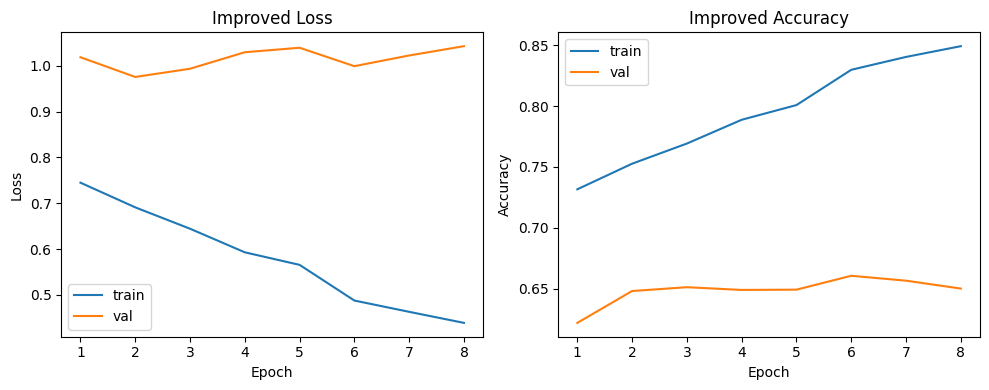

In [28]:
plot_history(hist_improved, title_prefix='Improved')


=== Test (Improved) metrics (macro) ===
Accuracy: 0.6483
Precision (macro): 0.4696
Recall (macro): 0.3918
F1-score (macro): 0.4002

=== Test (Improved) metrics (weighted) ===
Accuracy: 0.6483
Precision (weighted): 0.6342
Recall (weighted): 0.6483
F1-score (weighted): 0.6278


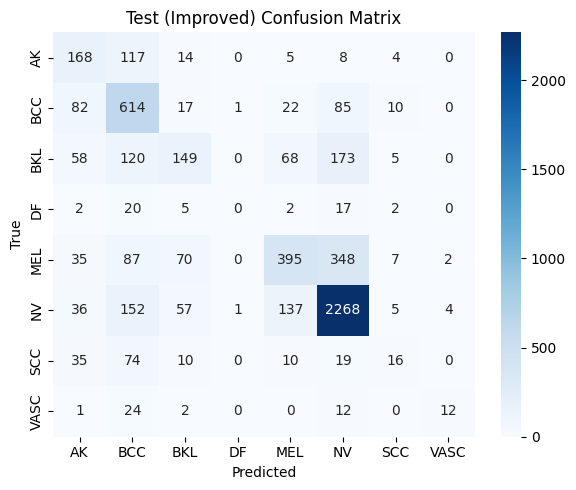

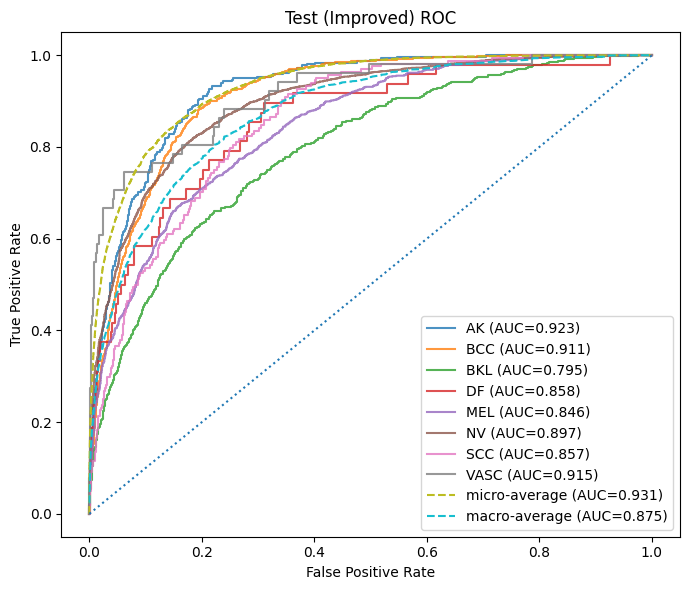


Classification report (per-class):

              precision    recall  f1-score   support

          AK       0.40      0.53      0.46       316
         BCC       0.51      0.74      0.60       831
         BKL       0.46      0.26      0.33       573
          DF       0.00      0.00      0.00        48
         MEL       0.62      0.42      0.50       944
          NV       0.77      0.85      0.81      2660
         SCC       0.33      0.10      0.15       164
        VASC       0.67      0.24      0.35        51

    accuracy                           0.65      5587
   macro avg       0.47      0.39      0.40      5587
weighted avg       0.63      0.65      0.63      5587



In [29]:
full_evaluation(improved, test_data, split_name='Test (Improved)')

# 7. Transfer learning model

### 7.1 Design

In [20]:
def build_transfer_model(backbone='resnet50', target_size=(224, 224),
                         head_units=128, dropout=0.3):
    """
    Frozen feature extractor with an internal resize from (IMG_HEIGHT, IMG_WIDTH) to target_size.
    Works with your generators that already use rescale=1./255.
    """
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # 1) Resize using a Keras layer (not tf.image.resize on a KerasTensor)
    x = layers.Resizing(target_size[0], target_size[1], interpolation='bilinear')(inputs)

    # 2) Your datagen rescales to [0,1]; preprocess_input expects [0,255]
    x = layers.Lambda(lambda t: t * 255.0, name="undo_rescale")(x)

    # 3) Backbone-specific preprocessing and base model
    b = backbone.lower()
    if b == 'resnet50':
        x = layers.Lambda(resnet_pre, name="preprocess_resnet")(x)
        base = ResNet50(include_top=False, weights='imagenet',
                        input_shape=target_size + (3,))
    elif b == 'vgg16':
        x = layers.Lambda(vgg_pre, name="preprocess_vgg")(x)
        base = VGG16(include_top=False, weights='imagenet',
                     input_shape=target_size + (3,))
    elif b == 'densenet121':
        x = layers.Lambda(densenet_pre, name="preprocess_densenet")(x)
        base = DenseNet121(include_top=False, weights='imagenet',
                           input_shape=target_size + (3,))
    else:
        raise ValueError("Unsupported backbone. Use 'resnet50', 'vgg16', or 'densenet121'.")

    # 4) Freeze backbone
    base.trainable = False

    # 5) Feature extraction + small head
    z = base(x, training=False)
    z = layers.GlobalAveragePooling2D()(z)
    z = layers.Dense(head_units, activation='relu')(z)
    z = layers.Dropout(dropout)(z)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(z)

    model = models.Model(inputs, outputs, name=f"TL_{backbone.upper()}")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### 7.2 Train

In [ ]:
tl_model = build_transfer_model(backbone='resnet50', target_size=(224,224), head_units=128, dropout=0.3)
hist_tl = train_model(tl_model, train_data, val_data, epochs=30, early_stopping=True)
tl_model.save('transfer_learning_skin_lesion_model.h5')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/30
133/140 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.5245 - loss: 1.4300

KeyboardInterrupt: 

### 7.3 Evaluation

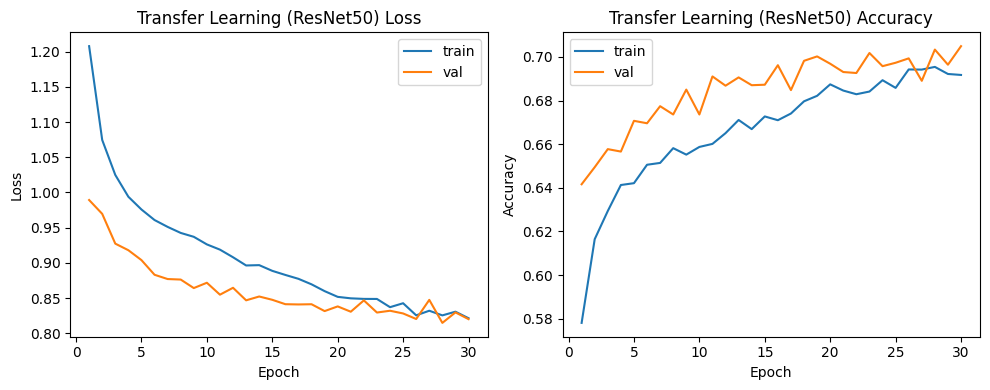

In [66]:
plot_history(hist_tl, title_prefix='Transfer Learning (ResNet50)')


=== Validation (TL) metrics (macro) ===
Accuracy: 0.3230
Precision (macro): 0.1230
Recall (macro): 0.1266
F1-score (macro): 0.1238

=== Validation (TL) metrics (weighted) ===
Accuracy: 0.3230
Precision (weighted): 0.2962
Recall (weighted): 0.3230
F1-score (weighted): 0.3080


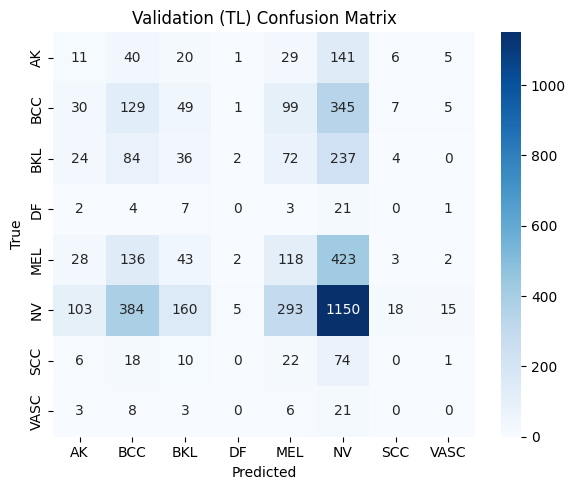

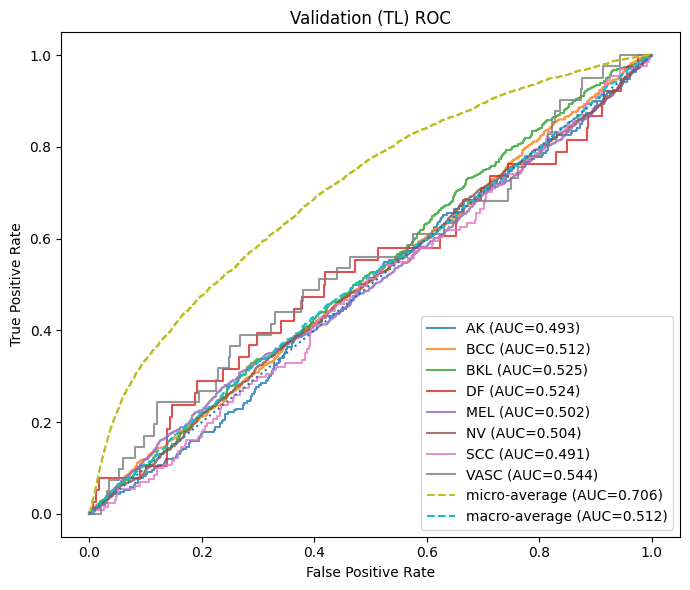


Classification report (per-class):

              precision    recall  f1-score   support

          AK       0.05      0.04      0.05       253
         BCC       0.16      0.19      0.18       665
         BKL       0.11      0.08      0.09       459
          DF       0.00      0.00      0.00        38
         MEL       0.18      0.16      0.17       755
          NV       0.48      0.54      0.51      2128
         SCC       0.00      0.00      0.00       131
        VASC       0.00      0.00      0.00        41

    accuracy                           0.32      4470
   macro avg       0.12      0.13      0.12      4470
weighted avg       0.30      0.32      0.31      4470



In [ ]:
full_evaluation(tl_model, test_data, split_name='Test (TL)')